# Parallel Programming - Final Project: Autoencoder for CIFAR-10

Class: 22KHMT

Students: Group 6
| No. | StudentID | Name              |
| :-: | --------- | ----------------- |
|  1  | 22127008  | Đặng Châu Anh     |
|  2  | 22127170  | Trần Dịu Huyền    |
|  3  | 22127359  | Chu Thúy Quỳnh    |

## Section 1: Problem Description  

**1. Problem Statement**

**2. CIFAR-10 Dataset Overview**

In [1]:
!unzip -o src.zip

Archive:  src.zip
   creating: src/
  inflating: src/data_loader.cpp     
  inflating: src/data_loader.h       
   creating: src/phase1/
  inflating: src/phase1/autoencode.cpp  
  inflating: src/phase1/autoencoder.h  
  inflating: src/phase1/cpu_layers.cpp  
  inflating: src/phase1/cpu_layers.h  
  inflating: src/phase1/train.cpp    
  inflating: src/utils.h             


cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin
cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin
cifar-10-batches-bin/data_batch_4.bin
cifar-10-batches-bin/test_batch.bin
cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin
cifar-10-batches-bin/data_batch_2.bin
Dataset prepared.
Sample images from CIFAR-10:


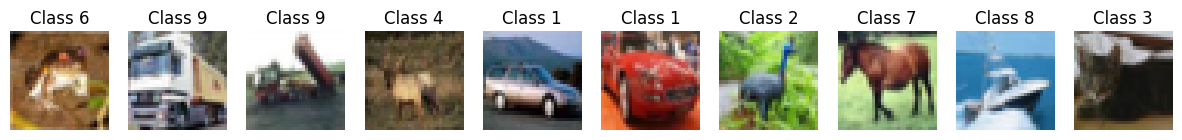

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile

# 1. Download & Extract Dataset
if not os.path.exists('data/cifar-10-batches-bin'):
    print("Downloading CIFAR-10...")
    !wget -q -P data https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
    !tar -xvf data/cifar-10-binary.tar.gz -C data/
    print("Dataset prepared.")

# 2. Visualize Samples (Python Helper)
def show_samples():
    # Helper to read a few binary bytes for visualization only
    # (Note: The C++ code handles the actual training data loading)
    with open('data/cifar-10-batches-bin/data_batch_1.bin', 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    # Reshape logic for CIFAR binary format (N, 3073)
    raw = data.reshape(-1, 3073)
    imgs = raw[:, 1:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i])
        ax.axis('off')
        ax.set_title(f"Class {raw[i, 0]}")
    plt.show()

print("Sample images from CIFAR-10:")
show_samples()

**3. Autoencoder Architecture**

**4. Project Objectives**

## Section 2: Implementation Phases

### Phase 2.1: CPU Baseline Implementation



**1. Objectives**

**2. Implementation Details**







* Data Pipeline

* Layer Implementation (CPU)

Key Code Snippet: Convolution Layer (Header)

In [3]:
!cat src/phase1/cpu_layers.h | grep -A 10 "class Conv2D"

class Conv2D {
public:
    int in_c, out_c, k_size, stride, pad;
    vector<float> weights, biases;
    vector<float> grad_w, grad_b;
    Tensor input_cache;

    Conv2D(int in, int out, int k=3, int s=1, int p=1);
    void init_weights();
    Tensor forward(const Tensor& input);
    Tensor backward(const Tensor& grad_out, float lr);


- Training Loop

**3. Execution & Results**

In [4]:
!g++ -o run_phase1 \
    src/phase1/*.cpp \
    src/*.cpp \
    -I./src \
    -O3

src/phase1/train.cpp: In function ‘int main(int, char**)’:
src/phase1/train.cpp:12:5: error: ‘CIFAR10Dataset’ was not declared in this scope
   12 |     CIFAR10Dataset dataset("./data/cifar-10-batches-bin");
      |     ^~~~~~~~~~~~~~
src/phase1/train.cpp:13:5: error: ‘dataset’ was not declared in this scope; did you mean ‘tzset’?
   13 |     dataset.load_data();
      |     ^~~~~~~
      |     tzset
src/data_loader.cpp:6:1: error: ‘CIFAR10Dataset’ does not name a type
    6 | CIFAR10Dataset::CIFAR10Dataset(const string& path) : data_dir(path) {}
      | ^~~~~~~~~~~~~~
src/data_loader.cpp:8:6: error: ‘CIFAR10Dataset’ has not been declared
    8 | void CIFAR10Dataset::load_data() {
      |      ^~~~~~~~~~~~~~
src/data_loader.cpp: In function ‘void load_data()’:
src/data_loader.cpp:10:20: error: ‘data_dir’ was not declared in this scope
   10 |         read_batch(data_dir + "/data_batch_" + to_string(i) + ".bin", train_images, train_labels);
      |                    ^~~~~~~~
src/data_l

In [5]:
!./run_phase1

/bin/bash: line 1: ./run_phase1: No such file or directory
